# Results for GDF+PCA+MLP for 30 runs

Here we present results for the best MLPs choosen based on best MCC (matthews) score on validation set. 
The features for MLPs are GDFs reduced by PCA (number of components is chosen based on sum of explained variance ratio > 0.99).

Because MLPs are not deterministic, the scores may vary, so we calculated scores 30 times for each model. Next we took mean obtained scores, so we can compare with scores obtained for Logistic Regression on Queue Imbalance feature (QUE+LOG).


In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_dir = 'res_gdf_pca_mlp_iter'
data_dir_que_log = '../queue_imbalance/res_que_log'
if_should_savefig = False

In [3]:
df_log = pd.DataFrame()
for f in os.listdir(data_dir_que_log):
    if 'csv' not in f:
        continue
    d = pd.read_csv(os.path.join(data_dir_que_log, f))
    df_log = df_log.append(d)

## Data 

Columns with suffix `MLP` are scores obtained using GDF+PCA+MLP.

Columns with suffix `log` are scores obtained using QUE+LOG.

Columns with *prefix* `diff` are differences of scores between MLPs - LOGs.

`r`, `s` - parameters for GDF (s - sigma, r - scale).

In [4]:
df_res = pd.DataFrame()
for f in os.listdir(data_dir):
    if 'csv' not in f:
        continue
    stock = f.split('_')[3]
    r = f.split('_')[5][1:]
    s = f.split('_')[6][1:-4]
    l = pd.read_csv(os.path.join(data_dir, f))
    l['stock'] = np.zeros(len(l)) + int(stock)
    l['r'] = np.zeros(len(l)) + float(r)
    l['s'] = np.zeros(len(l)) + float(s)
    l.drop(columns=[c for c in l.columns if 'Unnamed' in c], inplace=True)
    df_res = df_res.append(l, ignore_index=True)  

columns = ['matthews', 'test_matthews', 'stock', 'unit']
df_best = df_res.sort_values(by='matthews', ascending=False).groupby(['stock']).mean()
df_best = pd.merge(df_best, df_log, on='stock', suffixes=['_mlp', '_log'])
df_best = df_best.drop(columns=[c for c in df_best.columns if 'Unnamed' in c])
df_best.index = df_best['stock'].astype(int)

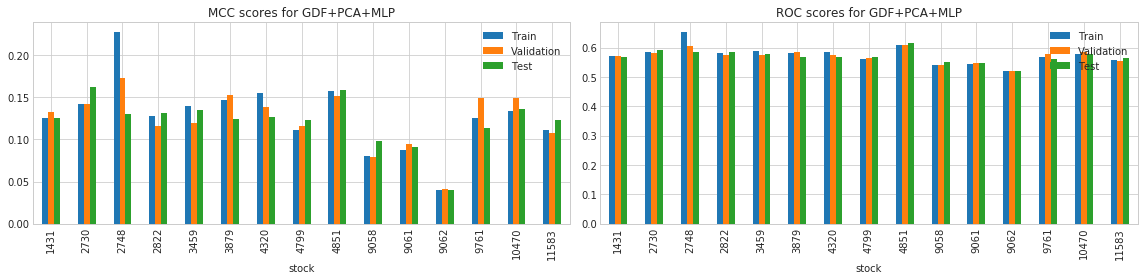

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

df_best[['train_matthews_mlp', 'matthews_mlp', 'test_matthews_mlp']].plot(kind='bar', ax=ax1)
ax1.legend(['Train', 'Validation', 'Test'])

ax1.set_title('MCC scores for GDF+PCA+MLP')

df_best[['train_roc_auc_mlp', 'roc_auc_mlp', 'test_roc_auc_mlp']].plot(kind='bar', ax=ax2)
ax2.legend(['Train', 'Validation', 'Test'])

ax2.set_title('ROC scores for GDF+PCA+MLP')
plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_mlp_mcc_roc_bar.png')

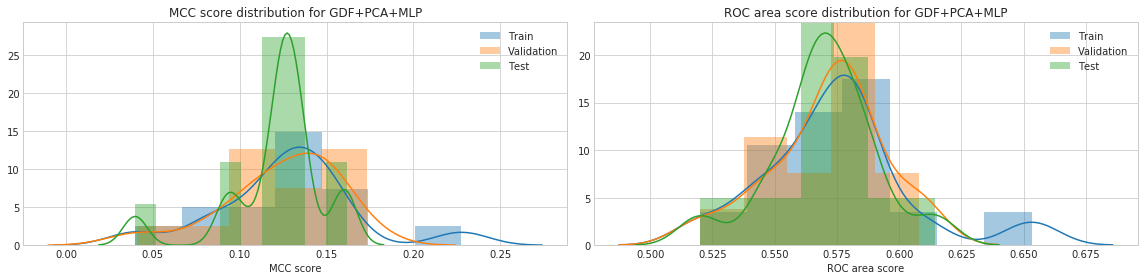

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.distplot(df_best['train_matthews_mlp'], label='Train', ax=ax1)
sns.distplot(df_best['matthews_mlp'], label='Validation', ax=ax1)
sns.distplot(df_best['test_matthews_mlp'], label='Test', ax=ax1)
ax1.legend(['Train', 'Validation', 'Test'])
ax1.set_title('MCC score distribution for GDF+PCA+MLP')
ax1.set_xlabel('MCC score')

sns.distplot(df_best['train_roc_auc_mlp'], label='Train', ax=ax2)
sns.distplot(df_best['roc_auc_mlp'], label='Validation', ax=ax2)
sns.distplot(df_best['test_roc_auc_mlp'], label='Test', ax=ax2)
ax2.legend(['Train', 'Validation', 'Test'])
ax2.set_title('ROC area score distribution for GDF+PCA+MLP')
ax2.set_xlabel('ROC area score')

plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_mlp_score_dist.png')

In [7]:
df_best[['train_matthews_mlp', 'matthews_mlp', 'test_matthews_mlp', 
        'train_roc_auc_mlp', 'roc_auc_mlp', 'test_roc_auc_mlp']].describe()

,train_matthews_mlp,matthews_mlp,test_matthews_mlp,train_roc_auc_mlp,roc_auc_mlp,test_roc_auc_mlp
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.127496,0.124227,0.121182,0.574643,0.571350,0.569692
std,0.041848,0.033867,0.029092,0.030806,0.023367,0.021724
min,0.039851,0.040740,0.039844,0.520022,0.519999,0.520039
25%,0.110767,0.111733,0.117986,0.559880,0.560199,0.562574
50%,0.127807,0.132029,0.125039,0.576860,0.575429,0.568468
75%,0.144726,0.148923,0.133237,0.583732,0.583881,0.581433
max,0.227642,0.173214,0.161993,0.653209,0.607803,0.614215


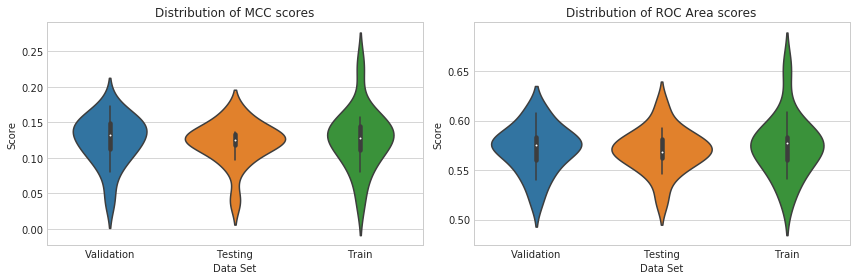

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

columns = ['stock', 'matthews_mlp', 'roc_auc_mlp', 
           'test_matthews_mlp', 'test_roc_auc_mlp', 'train_matthews_mlp', 'train_roc_auc_mlp']

df = df_best[columns].copy()
df.rename(columns={
    'matthews_mlp': 'Validation', 'test_matthews_mlp': 'Testing', 'train_matthews_mlp': 'Train'}, inplace=True)
df = df.melt(['stock', 'roc_auc_mlp', 'test_roc_auc_mlp', 'train_roc_auc_mlp'])
sns.violinplot(x="variable", y="value", data=df, ax=ax1)
ax1.set_title('Distribution of MCC scores')

ax1.set_xlabel('Data Set')
ax1.set_ylabel('Score')

df = df_best[columns].copy()
df.rename(columns={'roc_auc_mlp': 'Validation', 'test_roc_auc_mlp': 'Testing', 'train_roc_auc_mlp': 'Train'}, inplace=True)
df = df.melt(['stock', 'matthews_mlp', 'test_matthews_mlp', 'train_matthews_mlp'])

ax2.set_title('Distribution of ROC Area scores')

sns.violinplot(x="variable", y="value", data=df, ax=ax2)
ax2.set_xlabel('Data Set')
ax2.set_ylabel('Score')

plt.tight_layout()
if if_should_savefig:
    plt.savefig('violin_distribution_scores_gdf_pca_mlp.png')

## Comparision with QUE+LOG

In [9]:
df_best['diff_test_matthews'] = df_best['test_matthews_mlp'] - df_best['test_matthews_log']
df_best['diff_train_matthews'] = df_best['train_matthews_mlp'] - df_best['train_matthews_log']
df_best['diff_matthews'] = df_best['matthews_mlp'] - df_best['matthews_log']
df_best['diff_test_roc_auc'] = df_best['test_roc_auc_mlp'] - df_best['test_roc_auc_log']
df_best['diff_train_roc_auc'] = df_best['train_roc_auc_mlp'] - df_best['train_roc_auc_log']
df_best['diff_roc_auc'] = df_best['roc_auc_mlp'] - df_best['roc_auc_log']

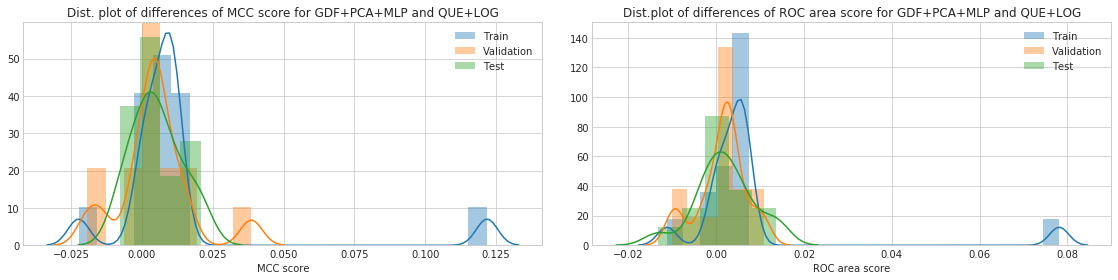

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.distplot(df_best['diff_train_matthews'], label='Train', ax=ax1)
sns.distplot(df_best['diff_matthews'], label='Validation', ax=ax1)
sns.distplot(df_best['diff_test_matthews'], label='Test', ax=ax1)
ax1.set_title('Dist. plot of differences of MCC score for GDF+PCA+MLP and QUE+LOG')
ax1.set_xlabel('MCC score')
ax1.legend()

sns.distplot(df_best['diff_train_roc_auc'], label='Train', ax=ax2)
sns.distplot(df_best['diff_roc_auc'], label='Validation', ax=ax2)
sns.distplot(df_best['diff_test_roc_auc'], label='Test', ax=ax2)
ax2.set_title('Dist.plot of differences of ROC area score for GDF+PCA+MLP and QUE+LOG')
ax2.set_xlabel('ROC area score')
ax2.legend()
plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_mlp_and_que_log_score_diff.png')

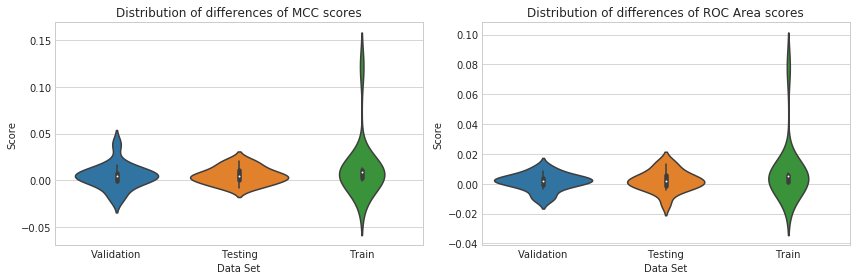

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

columns = ['stock', 'diff_matthews', 'diff_roc_auc', 
           'diff_test_matthews', 'diff_test_roc_auc', 'diff_train_matthews', 'diff_train_roc_auc']

df = df_best[columns].copy()
df.rename(columns={
    'diff_matthews': 'Validation', 'diff_test_matthews': 'Testing', 'diff_train_matthews': 'Train'}, inplace=True)
df = df.melt(['stock', 'diff_roc_auc', 'diff_test_roc_auc', 'diff_train_roc_auc'])
sns.violinplot(x="variable", y="value", data=df, ax=ax1)
ax1.set_title('Distribution of differences of MCC scores')

ax1.set_xlabel('Data Set')
ax1.set_ylabel('Score')

df = df_best[columns].copy()
df.rename(
    columns={'diff_roc_auc': 'Validation', 'diff_test_roc_auc': 'Testing', 'diff_train_roc_auc': 'Train'}, 
    inplace=True)
df = df.melt(['stock', 'diff_matthews', 'diff_test_matthews', 'diff_train_matthews'])

ax2.set_title('Distribution of differences of ROC Area scores')

sns.violinplot(x="variable", y="value", data=df, ax=ax2)
ax2.set_xlabel('Data Set')
ax2.set_ylabel('Score')

plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_mlp_and_que_log_violin_score_diff.png')

The table below shows the values for the differences, which distributions are on a plot above.

In [12]:
df_best[['diff_train_matthews', 'diff_matthews', 'diff_test_matthews', 
        'diff_train_roc_auc', 'diff_roc_auc', 'diff_test_roc_auc']].describe()

,diff_train_matthews,diff_matthews,diff_test_matthews,diff_train_roc_auc,diff_roc_auc,diff_test_roc_auc
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.012689,0.004617,0.005204,0.007879,0.001283,0.001977
std,0.031407,0.013126,0.008687,0.019979,0.005600,0.006821
min,-0.022337,-0.019246,-0.007889,-0.011232,-0.010118,-0.013199
25%,0.002647,-0.000417,-0.000112,0.001338,-0.000799,-0.001400
50%,0.008707,0.004686,0.004071,0.004893,0.001778,0.001647
75%,0.010807,0.008162,0.010547,0.006100,0.003615,0.005643
max,0.121803,0.038596,0.020761,0.078125,0.010789,0.013516


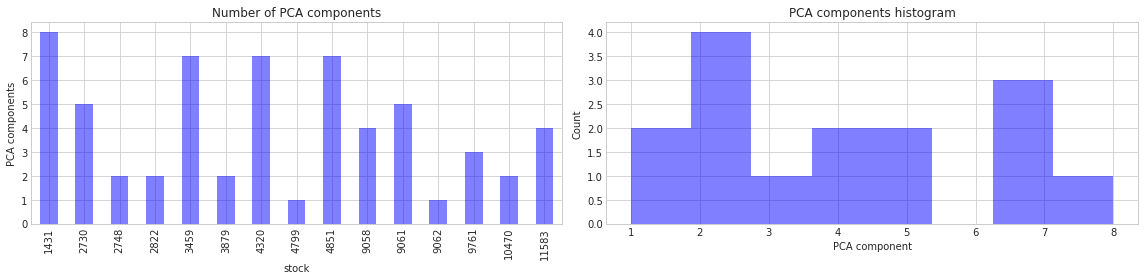

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
df_best['pca_components'].plot(kind='bar', color=['b'], alpha=0.5, ax=ax1)
ax1.set_title('Number of PCA components')
ax1.set_ylabel('PCA components')

# sns.distplot(df_best['pca_components'], ax=ax2, bins=10, kde=False)
df_best['pca_components'].hist(color='b', alpha=0.5, bins=8)
ax2.set_title('PCA components histogram')
ax2.set_ylabel('Count')
ax2.set_xlabel('PCA component')


plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_mlp_pca_components.png')

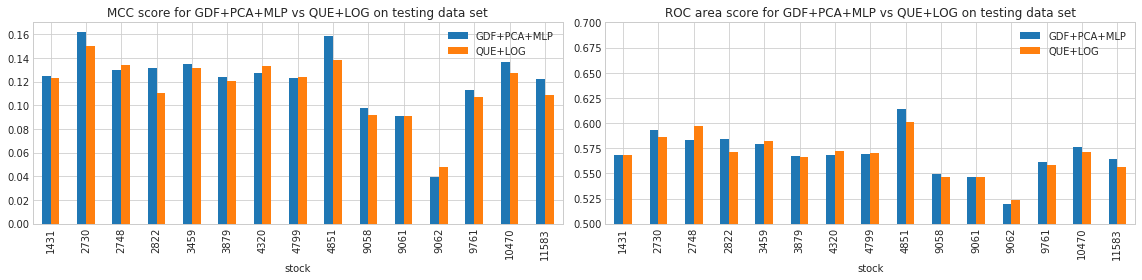

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
df_best[['test_matthews_mlp', 'test_matthews_log']].plot(kind='bar', ax=ax1)
ax1.legend(['GDF+PCA+MLP', 'QUE+LOG'])
ax1.set_title('MCC score for GDF+PCA+MLP vs QUE+LOG on testing data set')

df_best[['test_roc_auc_mlp', 'test_roc_auc_log']].plot(kind='bar', ax=ax2)
ax2.legend(['GDF+PCA+MLP', 'QUE+LOG'])
ax2.set_ylim(0.5, 0.7)
ax2.set_title('ROC area score for GDF+PCA+MLP vs QUE+LOG on testing data set')
plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_mlp_que_log_mcc_roc_scores_bar.png')

In [15]:
print('stocks having worse roc area score for MLP vs LOG on test set')
print(df_best[df_best['test_roc_auc_mlp'] < df_best['test_roc_auc_log']]['stock'].values)
df_best[df_best['test_roc_auc_mlp'] < df_best['test_roc_auc_log']][[
    'roc_auc_mlp', 'roc_auc_log', 'test_roc_auc_mlp', 'test_roc_auc_log', 'r', 's']]

stocks having worse roc area score for MLP vs LOG on test set
[2748. 3459. 4320. 4799. 9062.]


,roc_auc_mlp,roc_auc_log,test_roc_auc_mlp,test_roc_auc_log,r,s
stock,,,,,,
2748,0.606672,0.595883,0.583449,0.596648,0.01,0.5
3459,0.575432,0.577445,0.579417,0.581821,0.10,0.1
4320,0.575429,0.569999,0.568468,0.572275,0.10,0.1
4799,0.565283,0.573902,0.569578,0.569974,0.10,0.1
9062,0.519999,0.530117,0.520039,0.524008,0.01,0.5


In [16]:
print('stocks having worse MCC score for MLP vs LOG on test set')
df_best[df_best['test_matthews_mlp'] < df_best['test_matthews_log']][[
    'matthews_mlp', 'matthews_log', 'test_matthews_mlp', 'test_matthews_log', 'r', 's']]

stocks having worse MCC score for MLP vs LOG on test set


,matthews_mlp,matthews_log,test_matthews_mlp,test_matthews_log,r,s
stock,,,,,,
2748,0.173214,0.134618,0.130275,0.134365,0.01,0.5
4320,0.138583,0.129040,0.127274,0.133488,0.10,0.1
4799,0.116275,0.130257,0.123365,0.124104,0.10,0.1
9062,0.040740,0.059986,0.039844,0.047732,0.01,0.5


In [17]:
df_best[['train_matthews_mlp', 'train_matthews_log',
    'matthews_mlp', 'matthews_log', 'test_matthews_mlp', 'test_matthews_log', 'r', 's']]

,train_matthews_mlp,train_matthews_log,matthews_mlp,matthews_log,test_matthews_mlp,test_matthews_log,r,s
stock,,,,,,,,
1431,0.126033,0.117325,0.132029,0.134712,0.125039,0.123369,0.10,0.1
2730,0.142070,0.132427,0.142271,0.136898,0.161993,0.150063,0.10,0.5
2748,0.227642,0.105838,0.173214,0.134618,0.130275,0.134365,0.01,0.5
2822,0.127807,0.120714,0.116082,0.111058,0.131195,0.110434,0.01,0.1
3459,0.139720,0.129942,0.119873,0.122005,0.135279,0.131207,0.10,0.1
3879,0.147381,0.136130,0.152624,0.136745,0.123917,0.120715,0.01,0.1
4320,0.155672,0.142331,0.138583,0.129040,0.127274,0.133488,0.10,0.1
4799,0.110838,0.111690,0.116275,0.130257,0.123365,0.124104,0.10,0.1
4851,0.157004,0.146106,0.152044,0.148009,0.158242,0.138621,0.10,0.1


## Conclusions

GDF+PCA+MLP is not always better from QUE+LOG but for 75% of stocks it is.